Finding sorted position of every node to every other node is $\mathcal{O}(n^2\log{n})$. Pretty inefficient.

In [126]:
class Node:
    pos: numpy.array

    def __init__(self, pos):
        self.pos = pos
        
nodes = []
nodes.append(Node(numpy.array([0, 0])))
nodes.append(Node(numpy.array([1, 0])))
nodes.append(Node(numpy.array([3, 2])))
nodes.append(Node(numpy.array([4, 1])))
nodes.append(Node(numpy.array([2, 3])))

# Distances to all other nodes for any given noade
distances = [[] for node in nodes]

for i, node_a in enumerate(nodes):
    for j, node_b in enumerate(nodes):
        if i != j:
            node_tuple = (j, numpy.linalg.norm(node_a.pos - node_b.pos))
            distances[i].append(node_tuple)
    distances[i] = sorted(distances[i], key=lambda x: x[1])

distances

[[(1, 1.0),
  (2, 3.605551275463989),
  (4, 3.605551275463989),
  (3, 4.123105625617661)],
 [(0, 1.0),
  (2, 2.8284271247461903),
  (3, 3.1622776601683795),
  (4, 3.1622776601683795)],
 [(3, 1.4142135623730951),
  (4, 1.4142135623730951),
  (1, 2.8284271247461903),
  (0, 3.605551275463989)],
 [(2, 1.4142135623730951),
  (4, 2.8284271247461903),
  (1, 3.1622776601683795),
  (0, 4.123105625617661)],
 [(2, 1.4142135623730951),
  (3, 2.8284271247461903),
  (1, 3.1622776601683795),
  (0, 3.605551275463989)]]

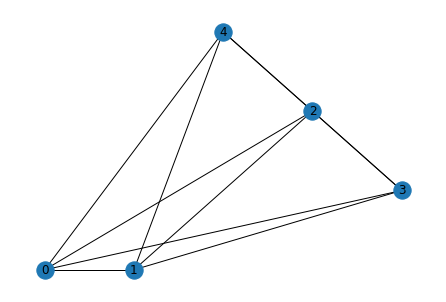

In [129]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for i, node in enumerate(nodes):
    G.add_node(i, pos=node.pos)
    for to in distances[i]:
        G.add_edge(i, to[0])
    

pos=nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True)
plt.show()